<a href="https://colab.research.google.com/github/ajmeek/procgen-tools/blob/paper_graphics/Visualizing_goal_misgeneralization_activations_paper_graphics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf /content/procgen-tools


In [1]:
# try:
#     import procgen_tools
# except ModuleNotFoundError:
#     #commit = '09877d5a9fe0609c2a3792ddda3b45a83ace61f9'
#     #get_ipython().run_line_magic(magic_name='pip', line=f'install -U git+https://github.com/ajmeek/procgen-tools.git@{commit}')
#     pass

get_ipython().run_line_magic(magic_name='pip', line=f'install -U git+https://github.com/ajmeek/procgen-tools.git@paper_graphics')


from procgen_tools.utils import setup

setup() # create directory structure and download data

  Cloning https://github.com/ajmeek/procgen-tools.git (to revision paper_graphics) to /tmp/pip-req-build-tx1_9_8t
  Running command git clone --filter=blob:none --quiet https://github.com/ajmeek/procgen-tools.git /tmp/pip-req-build-tx1_9_8t
  Running command git checkout -b paper_graphics --track origin/paper_graphics
  Switched to a new branch 'paper_graphics'
  Branch 'paper_graphics' set up to track remote branch 'paper_graphics' from 'origin'.
  Resolved https://github.com/ajmeek/procgen-tools.git to commit cc51d2ff1fbc5984cb274b492fcef13a576082f2
  Preparing metadata (setup.py) ... done
Already downloaded https://nerdsniper.net/mats/model_rand_region_5.pth


In [2]:
from procgen_tools.imports import *
from procgen_tools import visualization

# Visualizing details of the goal misgeneralization nets
Let's understand lots of details about [the goal misgeneralization paper](https://arxiv.org/abs/2105.14111).

Let's visualize the network structure. Here's a Mermaid diagram.

![](https://i.imgur.com/5oSHoVQ.png)

This network is actually substantially overparameterized. The convolutional layers have a `scale` setting, which is set to 4 in Langosco et al.'s trained networks. `scale` affects how many channels there are at various parts of the net. For example, there are `32*scale` residual channels in the second and third Impala blocks. Training performance and generalization seems similar for `scale=1` and `scale=4`.

In [8]:
visualization.plot_layer_stats(hook, mode="parameters")

In [9]:
visualization.plot_layer_stats(hook, mode="activations")

# Visualizing actual observation activations

## Code for visualization

In [3]:
from google.colab import output
output.enable_custom_widget_manager()

In [60]:
from procgen_tools.procgen_imports import *

class ActivationsPlotterColab:
    def __init__(self, labels: List[str], plotter: Callable, activ_gen: Callable, hook, coords_enabled: bool=False, defaults : dict = None, save_dir='experiments/visualizations', title: str='', **act_kwargs):
        """
        labels: The labels of the layers to plot
        plotter: A function that takes a label, channel, and activations and plots them
        activ_gen: A function that takes a label and obs and returns the activations which should be sent to plotter
        hook: The hook that contains the activations
        coords_enabled: Whether to enable the row and column sliders
        defaults: A dictionary of default values for the plotter, where the keys are attributes of this class which themselves have the "value" attribute. The class value will be set to the corresponding dictionary value.
        act_kwargs: Keyword arguments to pass to the activations generator
        """
        self.fig = go.Figure()
        self.plotter = plotter
        self.activ_gen = activ_gen
        self.act_kwargs = act_kwargs
        self.hook = hook
        self.save_dir = save_dir
        self.title = title

        #self.fig.layout.title = {'text': self.title}

        # Remove the _out layer and "embedder." prefixes
        formatted_labels = format_labels(labels)
        print("formatted labels = ", formatted_labels)
        self.label_widget = Dropdown(options=formatted_labels, value=formatted_labels[0], description="Layers")
        self.channel_slider = IntSlider(min=0, max=127, step=1, value=0, description="Channel")

        # Add channel increment and decrement buttons
        button_width = '10px'
        decrement_button, increment_button = [Button(description=descr_str, layout=Layout(width=button_width)) for descr_str in ("-", "+")]
        def add_to_slider(x : int):
            # Clip the value to the min and max
            self.channel_slider.value = np.clip(self.channel_slider.value + x, self.channel_slider.min, self.channel_slider.max)
            self.update_plotter()
        decrement_button.on_click(lambda _: add_to_slider(-1))
        increment_button.on_click(lambda _: add_to_slider(1))
        self.widgets = [self.fig, self.label_widget, HBox([self.channel_slider, decrement_button, increment_button])] # TODO make this a helper for converting arbitrary sliders

        # Add row and column sliders if enabled
        self.coords_enabled = coords_enabled
        if coords_enabled:
            self.col_slider, self.row_slider = (IntSlider(min=0, max=62, step=1, value=32, description="Column"), IntSlider(min=0, max=63, step=1, value=32, description="Row"))
            self.widgets.extend([self.col_slider, self.row_slider])

        # Add a custom filename widget
        self.filename_widget = Text(value="", placeholder="Custom filename", disabled=False)
        self.filename_widget.layout.width = '150px'
        self.button = Button(description="Save image")
        self.button.on_click(self.save_image)
        self.widgets.append(HBox([self.filename_widget, self.button]))

        # Set the default values for the plotter, if provided
        if defaults is not None:
            for key, value in defaults.items():
                getattr(self, key).value = value

        # Ensure that the plot is updated when the widgets are changed
        for widget in self.widgets:
            if widget != self.fig:
                widget.observe(self.update_plotter, names='value')

        # Set the initial plot
        self.update_plotter()

    def display(self):
        """ Display the elements; this function separates functionality from display. """
        print("fig: ", self.fig)
        self.fig.layout['title'] = {'text': self.title}
        display(self.fig)
        display(VBox(self.widgets[1:-1])) # Show a VBox of the label dropdown and the sliders, centered beneath the plot
        display(self.widgets[-1])

    #changed to save in vectorized format - Austin
    def save_image(self, b): # Add a save button to save the image
        basename = self.filename_widget.value if self.filename_widget.value != "" else f"{self.label_widget.value}_{self.channel_slider.value}{f'_{self.col_slider.value}_{self.row_slider.value}' if self.coords_enabled else ''}"
        filepath = f"{self.save_dir}/{basename}.svg"

        # Annotate to the outside of the plot

        old_title = self.fig.layout.title
        #old_title = 'Activations'

        print("old title: ", old_title)


        # if self.title is not '':
        self.fig.layout.title = f"{self.title}"#;\nchannel {self.channel_slider.value}{f' at ({self.col_slider.value}, {self.row_slider.value})' if self.coords_enabled else ''}"
        # else:
        #     self.fig.layout.title = self.title

        self.fig.update_yaxes(autorange="reversed")
        self.fig.write_image(filepath, format='svg')
        print(f"Saved image to {filepath}")

        self.fig.layout.title = old_title # Clear the title
        #self.fig.layout.title = self.title

        self.filename_widget.value = "" # Clear the filename_widget box

    def update_plotter(self, b=None):
        """ Update the plot with the current values of the widgets. """
        label = expand_label(self.label_widget.value)
        self.channel_slider.max = models.num_channels(hook=self.hook, layer_name=label) - 1
        channel = self.channel_slider.value = min(self.channel_slider.value, self.channel_slider.max)

        if self.coords_enabled:
            col, row = self.col_slider.value, self.row_slider.value
            activations = self.activ_gen(row, col, label, self.hook, **self.act_kwargs)
        else:
            activations = self.activ_gen(label, self.hook, **self.act_kwargs) # shape is (b, c, h, w) at conv layers, (b, activations) at linear layers

        if len(activations.shape) == 2: # Linear layer (batch, hidden_dim)
            # Ensure shape[1] is a perfect square
            sqrt_act = int(math.sqrt(activations.shape[1]))
            if sqrt_act * sqrt_act == activations.shape[1]:
                activations = np.reshape(activations, newshape=(activations.shape[0], 1, sqrt_act, sqrt_act)) # Make a dummy channel dimension
                # Annotate that there is no spatial meaning to the activations
                self.fig.update_layout(title_text=f"{self.label_widget.value}; reshaped to 2D; no spatial meaning")
            else:
                activations = np.expand_dims(activations, axis=(1,2)) # Add a dummy dimension to the activations

        self.plotter(activations=activations[:, channel], fig=self.fig) # Plot the activations
        format_plotter(fig=self.fig, activations=activations, is_policy_out=self.label_widget.value == 'fc_policy_out', title=self.label_widget.value)

Trying to plot patches below. For now, use the regular code above ^

## Visualization suite
Unfortunately, Colab doesn't support `plotly`'s `FigureWidget` functionality, so live updating of activations won't work here. You can instead configure a level on your copy of the runtime, and then re-render e.g. `channel=55`'s activations by running the lower code block.

To enjoy live editing, clone [our repo](https://github.com/UlisseMini/procgen-tools) and e.g. run the (unfinished) notebook `experiments/visualize_activations.ipynb`.

In [ ]:
from procgen_tools import maze, visualization

SEED = 0
venv = maze.create_venv(num=1, start_level=SEED, num_levels=1)

widget_box = visualization.custom_vfield(policy, venv=venv, show_components=True)
display(widget_box)

Box(children=(HBox(children=(GridspecLayout(children=(Button(layout=Layout(grid_area='widget001', height='0px'…

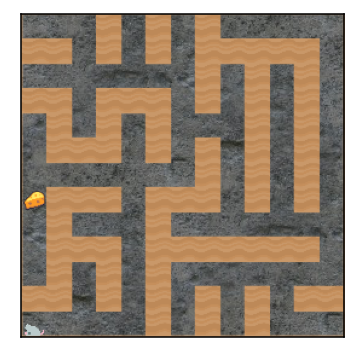

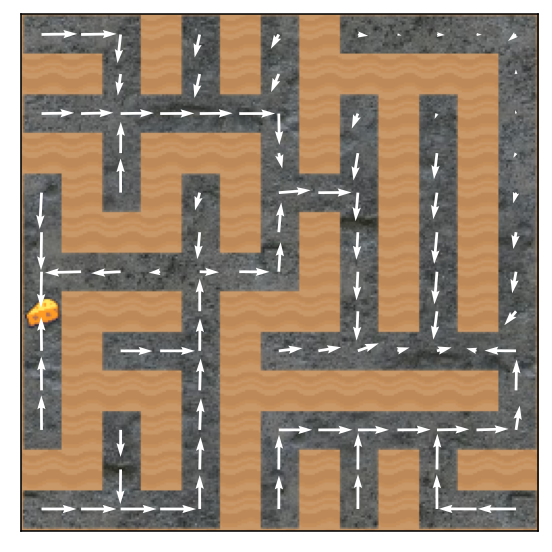

In [ ]:
#trying visualization. just do one on the right. Unfortunately I don't see a quick way to suppress the array output

visualization.visualize_venv(venv, show_plot = True, render_padding = False)

#now need to plot the vector field. When I determine the most probable path, probably do it with a new render arrows function - mpp as a new func or extra param.
#also since I'll be changing the visualization file, change the import statement above to install the code from my branch

vf = visualization.vector_field(venv, policy)

visualization.plot_vf(vf)

#so the vf does not include the mouse. May need to add it manually, but it'd be easier to add normally.

Thoughts on this.
The patches do not apply the patches to the venv object, which is all that gets passed in to the activation plotter. Can I apply the patches?

Alex's patch plotting function should be fine. Just add another param to the activationsplotter.
Actually I am having some trouble with that. Let me instead try to apply patches to the venv object.

So I can use hook.use_patches(patches) to get a new hook.network (a modified policy). See 437 of patch_utils, where we apply a patch to compare vfields.

In ActivationsPlotter I'm now doing with self.hook.use_patches(patches): etc... to then call the activations func, which is

In [61]:
from procgen_tools import patch_utils

settings = {'channel_slider': 55, 'label_widget': 'block2.res1.resadd_out'}

print(default_layer)

venv = patch_utils.get_cheese_venv_pair(seed=0)
patches = patch_utils.get_channel_pixel_patch(layer_name='embedder.block2.res1.resadd_out',channel=55, value=5.6, coord=(7,9), default=0.0)
#visualization.plot_patch(patches, hook, bounds=(13,13))

custom_maze_plotter = ActivationsPlotterColab(labels, lambda activations, fig: plot_activations(activations[0], fig=fig), patch_utils.values_from_venv, hook, save_dir='/content/experiments/visualizations',defaults=settings, title='Activations', venv=venv)

#with hook.use_patches(patches):
#custom_maze_plotter = ActivationsPlotterColabPatches(patches, labels, lambda activations, fig: plot_activations(activations[0], fig=fig), patch_utils.values_from_venv_patched, hook, defaults=settings, venv=venv)
custom_maze_plotter.display()

embedder.block2.res1.resadd_out
formatted labels =  ['block1.conv_in0', 'block1.conv_out', 'block1.maxpool_out', 'block1.res1.relu1_out', 'block1.res1.conv1_out', 'block1.res1.relu2_out', 'block1.res1.conv2_out', 'block1.res1.resadd_out', 'block1.res2.relu1_out', 'block1.res2.conv1_out', 'block1.res2.relu2_out', 'block1.res2.conv2_out', 'block1.res2.resadd_out', 'block2.conv_out', 'block2.maxpool_out', 'block2.res1.relu1_out', 'block2.res1.conv1_out', 'block2.res1.relu2_out', 'block2.res1.conv2_out', 'block2.res1.resadd_out', 'block2.res2.relu1_out', 'block2.res2.conv1_out', 'block2.res2.relu2_out', 'block2.res2.conv2_out', 'block2.res2.resadd_out', 'block3.conv_out', 'block3.maxpool_out', 'block3.res1.relu1_out', 'block3.res1.conv1_out', 'block3.res1.relu2_out', 'block3.res1.conv2_out', 'block3.res1.resadd_out', 'block3.res2.relu1_out', 'block3.res2.conv1_out', 'block3.res2.relu2_out', 'block3.res2.conv2_out', 'block3.res2.resadd_out', 'relu3_out', 'flatten_out', 'fc_out', 'relufc_out

old title:  layout.Title({
    'text': 'Activations'
})
Saved image to /content/experiments/visualizations/block2.res1.resadd_out_55.svg
